# I. Tổng quan dữ liệu
## 1. Phát biểu bài toán
   Dự đoán giá của sản phẩm với các đặc trưng cho trước, đã có bộ dữ liệu huần luyện gồm các sản phẩm, đặc trưng và giá. Đây là bài toán hồi quy tuyến tính. 

## 2. Nhìn qua cấu trúc dữ liệu

### Import thư viện giải nén dữ liệu train

In [ ]:
from IPython.display import clear_output
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
clear_output()

### Cấu trúc dữ liệu

In [ ]:
train_df = pd.read_table('train.tsv')
train_df.head()

Mỗi hàng biểu diễn một sản phẩm với 7 thuộc tính bao gồm: name, item_condition_id, category_name, brand_name, price, shipping và item descrption.
Trong đó : input:name,item_condition_id,category_name,brand_name,shipping,item descrption
Output :price
Thuộc tính train_id không có giá trị, có thể bỏ đi.

In [ ]:
train_df = train_df.drop('train_id', axis=1)

### Mô tả đơn giản về dữ liệu

In [ ]:
train_df.info()

Tập dữ liệu này chứa 1482535 mẫu, có thể coi là đủ lớn cho một mô hình học máy. Lưu ý rằng, các thuộc tính category_name, brand_name và item_desciption có các giá trị null và ta sẽ cần xử lý vấn đề này.  
Dữ liệu bao gồm:
1. 2 thuộc tính dạng văn bản là name và item_description.
2. 2 thuộc tính dạng nhãn là category_name và brand_name.
3. 2 thuộc tính có giá trị số là item_condition_id và shipping, nhưng chúng vẫn thuộc kiểu dữ liệu dạng nhãn.
4. price có giá trị số thực.

## 3. Tổng quan về từng thuộc tính

**Ta sẽ xem qua phân phối các thuộc tính không thuộc dạng văn bản.**

### price

Phân phối của output vô cùng quan trọng trong Học máy, nó quyết định khả năng hội tụ của hàm dự đoán. Theo định lý giới hạn trung tâm, kết quả tính toán sẽ hội tụ về một giá trị của phân phối ngẫu nhiên. Từ đó, thông thường, trong trường hợp lý tưởng, phân phối của ouput sẽ có thể giản lược về dạng phân phối chuẩn, giúp quá trình hội tụ diễn ra dễ dàng hơn, là mấu chốt của việc huấn luyện mô hình hồi quy tuyến tính.

Đồ thị phân phối của price:

In [ ]:
plt.figure(figsize=(7, 7))
sns.histplot(train_df['price'], kde=False, stat="density", linewidth=0)
plt.show()

Biểu diễn đồ thị một cách dễ nhìn hơn, kèm theo phân phối chuẩn maximum likelihood

In [ ]:
from scipy.stats import norm
plt.figure(figsize=(7, 7))
ax = sns.distplot(train_df['price'], fit=norm, kde=False)
ax.set_xlim(0, 250)
plt.show()

Dữ liệu phân phối rất và phương sai lớn, rất khó để quan sát. Vì vậy, để thu hẹp khoảng giá trị ta sẽ tiến hành biểu diễn trên giá trị log của nó:

In [ ]:
plt.figure(figsize=(7, 7))
sns.distplot(np.log1p(train_df['price']), fit=norm, kde=False)
plt.show()

Phân phối của log1p của price gần như một phân phối chuẩn, là một giá trị lí tưởng để tính toán, vì vậy ta sẽ sử dụng luôn giá trị này làm output để huần luyện mô hình. Trong quá trình dự đoán, kết quả sẽ được trả về đúng chuẩn bằng hàm exp1p.

In [ ]:
train_df['price'] = np.log1p(train_df['price'])

### Các thuộc tính dạng nhãn

Phân phối số lần xuất hiện của mỗi giá trị trong tập giá trị sẽ giúp ta đánh giá được các giá trị ảnh hưởng nhiều hay ít đến kết quả dầu ra, từ đó có thể tập trung, xử lý các giá trị rỗng hoặc lược bỏ một số giá trị.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_value_count(column):
    value_count  = train_df[column].value_counts()
    value_count = value_count[:5]
    plt.figure(figsize=(10,5))
    g = sns.barplot(x=value_count.index, y=value_count.values, alpha=0.8)
    g.bar_label(g.containers[0])
    plt.title('Top {} value count'.format(column))
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.show()

**item_condition_id**

In [ ]:
visualize_value_count('item_condition_id')

**brand_name**

In [ ]:
visualize_value_count('brand_name')

**shipping**

In [ ]:
visualize_value_count('shipping')

**category_name**

Với thuộc tính category_name, ta nhận thấy nó gồm 3 phần riêng biệt kết hợp với nhau, vì vậy ta sẽ tiến hành tách nó thành 3 thuộc tính riêng biệt.

In [ ]:
def get_cat(cat):
    try:
        return cat.split('/')
    except:
        return [None, None, None]

In [ ]:
train_df['cat_1'], train_df['cat_2'], train_df['cat_3'] = zip(*train_df['category_name'].apply(lambda x: get_cat(x)))
train_df = train_df.drop('category_name', axis=1)

**Phân phối cho các thuộc tính mới cat_1, cat_2, cat_3**

In [ ]:
visualize_value_count('cat_1')

In [ ]:
visualize_value_count('cat_2')

In [ ]:
visualize_value_count('cat_3')

Nhìn lại mô tả về dữ liệu mới:

In [ ]:
train_df.info()

Nhận xét: Các giá trị có trọng số cao đều chiếm một phần kha khá trong dữ liệu tổng, vì vậy có thể lấp các giá trị null bằng các giá trị có trọng số cao này.

# II. Chuẩn bị dũ liệu cho mô hình - tiền xử lý

## 1. Chia input, output

In [ ]:
X = train_df.drop('price', axis=1)
y = train_df['price']

## 2. Làm sạch dữ liệu

Tách các thuộc tính theo kiểu dữ liệu:

In [ ]:
cat_features = ['brand_name', 'cat_1', 'cat_2', 'cat_3', 'shipping', 'item_condition_id']
text_features = ['name', 'item_description']

Với các dữ liệu dạng nhãn, ta tạo một bộ xử lý các mẫu mang giá trị null dựa trên SimpleImputer của sklearn.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.fill = 'No description yet'

    def fit(self, X, y=None):
        if self.strategy in ['mean','median']:
            if not all(X.dtypes == np.number):
                raise ValueError('dtypes mismatch np.number dtype is \required for '+ self.strategy)
        if self.strategy == 'mean':
            self.fill = X.mean()
        elif self.strategy == 'median':
            self.fill = X.median()
        elif self.strategy == 'mode':
            self.fill = X.mode().iloc[0]
        elif self.strategy == 'fill':
            self.fill = self.fill
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [ ]:
X_cat = X[cat_features]

Như đã nói ở trên, ta sẽ lấp các giá trị null bằng giá trị có trọng số lớn nhất.

In [ ]:
imputer = CustomImputer(strategy='mode')

In [ ]:
for col in X_cat.columns:
    X_cat[col] = imputer.fit_transform(X_cat[col])

Kiểm tra lại:

In [ ]:
X_cat[X['brand_name'].isnull()].head()

Với dữ liệu dạng văn bản, ta đơn giản thay các giá trị null bằng một giá trị đặc biệt, ví dụ 'No description yet'.

In [ ]:
X_text = X[text_features]

In [ ]:
imputer = CustomImputer(strategy='fill')

In [ ]:
for col in X_text.columns:
    X_text[col] = imputer.fit_transform(X_text[col])

Kiểm tra lại:

In [ ]:
X_text[X['item_description'].isnull()].head()

## 3. Xử lý dữ liệu không phải dạng số

Để làm đầu vào cho mô hình hồi quy dữ liệu dạng nhãn và văn bản cần chuyển về dạng số. Các thuộc tính này sẽ được chuyển thành một vector dạng one-hot (gồm 1 và 0), sau đó được gộp lại thành một ma trận thưa (sparse matrix) chỉ lưu vị trí các giá trị 0, có thể lưu trữ hàng nghìn danh mục.

**Với dữ liệu dạng văn bản**, ta sử dụng 2 thư viện vector hóa văn bản của sklearn là Count Vectorizer cho dạng văn bản ngắn là name, và TfidfVectorizer cho văn bản dài là item_description.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

**Dùng count vectorizer để xử lý name**

Count vectorizer chuyển văn bản thành một vector mà trong đó, giá trị của từng phần tử là số lần xuất hiện của từ đó trong văn bản.

In [ ]:
cnt_vec = CountVectorizer(max_features = 5000, stop_words='english')

In [ ]:
cnt_vec.fit_transform(X_text['name']).shape

Count vectorizer biến feature name thành vector mới với 5000 phần tử.

**Dùng TF-IDF để xử lý item_description**

TF-IDF chuyển văn bản thành một vector mà trong đó, giá trị của từng phần tử đánh giá tầm quan trọng của một từ trong một văn bản. Giá trị đó được tính theo công thức:
> ![](https://nguyenvanhieu.vn/wp-content/uploads/2019/01/tf.png)
  ![](https://nguyenvanhieu.vn/wp-content/uploads/2019/01/idf.png)   
  
> $tfidf(t, d, D) = tf(t, d) x idf(t, D)$

>Trong đó:
>   *       $tf(t, d$): tần suất xuất hiện của từ t trong văn bản d
>   *       $f(t, d)$: Số lần xuất hiện của từ t trong văn bản d
>   *       $max({f(w, d) : w ∈ d})$: Số lần xuất hiện của từ có số lần xuất hiện nhiều nhất trong văn bản d
>   *       $|D|$: Tổng số văn bản trong tập D
>   *       $|{d ∈ D : t ∈ d}|$: thể hiện số văn bản trong tập D có chứa từ t.*
            
 

Sử dụng tf idf với config max_features = 5000, ngram_range=(1, 2) và stop_words='english'.

In [ ]:
tfidf_descp = TfidfVectorizer(max_features = 5000, ngram_range=(1, 2), stop_words='english')

In [ ]:
tfidf_descp.fit_transform(X_text['item_description']).shape

Tf idf biến feadture item_description thành vector mới với giới hạn 5000 phần tử.

**Với dữ liệu dạng nhãn**, ta sử dụng thư viện của sklearn là OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder

**Ví dụ với brand_name**

In [ ]:
oh_brand_name = OneHotEncoder(handle_unknown='ignore')

In [ ]:
oh_brand_name.fit_transform(X_cat[['brand_name']]).shape

brand_name giờ trở thành vector với 4809 phần tử.

## 4. Pipeline biến đổi

Để kết hợp các phép biến đổi một cách tuần tự, hệ thống và tổng quát, ta sử dụng lớp Pipeline của sklearn để biến đổi theo chuỗi như vậy. Sau đó sử dụng lớp ColumnTransformer để áp dụng biến đổi cho từng cột riêng biệt.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 

In [ ]:
cat_pipeline = Pipeline([
    ('imputer', CustomImputer(strategy='mode')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
name_pipeline = Pipeline([
    ('impter', CustomImputer(strategy='fill')),
    ('vector', CountVectorizer(max_features = 5000, stop_words='english'))
])

In [ ]:
text_pipeline = Pipeline([
    ('impter', CustomImputer(strategy='fill')),
    ('vector', TfidfVectorizer(max_features = 5000, ngram_range=(1, 2), stop_words='english'))
])

In [ ]:
full_pipeline = ColumnTransformer([
    ('cat', cat_pipeline, cat_features),
    ('name', name_pipeline, 'name'),
    ('text', text_pipeline, 'item_description'),
])

In [ ]:
X_prepared = full_pipeline.fit_transform(X)

In [ ]:
X_prepared

# III. Chọn và huấn luyện mô hình

## 1. Các mô hình cho bài toán

Ta sẽ lần lượt đi qua các mô hình từ mô hình cơ bản như Linear Regression, mô hình hạ gradient ngẫu nhiên SGD, mô hình có tham số điều chuẩn Ridge, cuối cùng là mô hình boosting XGBRegressor

### 1. Linear Regression

Linear Regression sẽ tối thiểu hoá phép đo MSE:

$MSE(X, h_{\theta}) = \frac{1}{m}\sum_{i=1}^{m}(\theta^{T}x^{(i)} - y^{(i)})^{2}$

bằng cách tính tham số của mô hình bằng cách giải nghiệm của Phương trình pháp tuyến - Normal Equation:

$\theta = (X^{T}X)^{-1}X^{T}y$

In [ ]:
from sklearn.linear_model import LinearRegression 
linear = LinearRegression()

Nhược điểm: Linear Regression giải phương trình trực tiếp nên mô hình sẽ bị overfit và rất nhạy cảm với nhiễu.

### 2. SGD

Hạ Gradient là thuật toán tối ưu tổng quát. Ý tưởng của hạ gradient là liên tục điều chỉnh các tham số để cực tiểu hoá phép đo, dựa vào giá trị đạo hàm riêng của hàm với tham số đó. Cụ thể, khi đi ngược hướng với đạo hàm, hàm số sẽ hội tụ, tiến dần đến điểm cực tiểu. Tốc độ biến thiên được quyết định bởi tham số learnig rate.

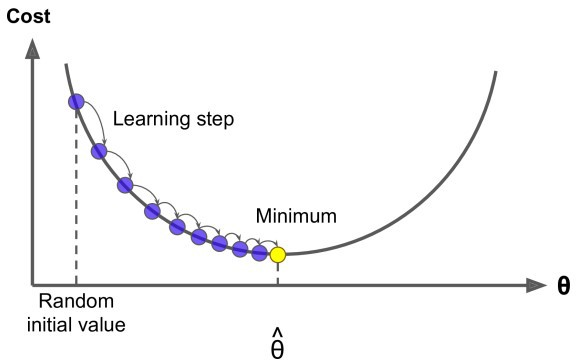!

Hạ Gradient ngẫu nhiên sẽ chọn ngẫu nhiên một phần tập dữ liệu theo batch để thực hiện đạo hàm, có thể làm giảm tốc đọ hội tụ nhưng tăng tình tổng quát.


In [ ]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(shuffle=True)

### 3. Ridge

Để giảm vấn đề overfit, mô hình cần thêm một tham số gọi là tham số điều chuẩn (Regularization).  
Cụ thể, Ridge có phép đo:

$J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{1}^{n}\theta^{2}_{i}$

Việc thêm tham số điều chuẩn $\alpha\frac{1}{2}\sum_{1}^{n}\theta^{2}_{i}$ vào hàm chi phí sẽ khiến mô hình không chỉ cần chính xác mà giá trị của các tham số phải nhỏ nhất có thể. Điều này khiến mô hình bớt nhạy cảm khi đầu vào thay đổi.

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
ridge = Ridge(solver='auto', fit_intercept=True, alpha=0.4, max_iter=1000, normalize=False, tol=0.01)

### 4. Boosting Model
Boosting là một thuật toán Ensemble Learning với phương pháp tổng hợp các weak learner thành một strong learner, trong đó lần lượt học các weak learner sao cho weak learner sau cải thiện weak learner trước.

Một thuật toán Boosting là Gradient Boosting. Trong Gradient Boosting, các learner sau sẽ học sai số của learner trước nó. Do đó, ensemble model sẽ dần dần khiến cho loss = 0.

XGBooost là phiên bản cải tiến của GBM (Gradient Boosting Model), với thuật toán cơ bản là Cây quyết định (Decision Tree), nó thực hiện việc xây dựng tuần tự nhiều Cây quyết định và tiến hành học.

XGBoost tối ưu các tài nguyên tính toán bằng cách xây dựng các cây Decision Tree một cách song song cùng các thuật toán tối ưu khác.

Ưu điểm của XGBoost:

* Tốc độ xử lý

    * XGBoost thực hiện tinh toán song song nên tốc độ xử lý có thể tăng gấp 10 lần so với GBM. Ngoài ra, XGboost còn hỗ trợ tính toán trên Hadoop.
* Overfitting

    * XGBoost áp dụng cơ chế Regularization nên hạn chế đáng kể hiện tượng Overfitting (GBM không có regularization).
* Sự linh hoạt

    * XGboost cho phép người dùng sử dụng hàm tối ưu và chỉ tiêu đánh giá của riêng họ, không hạn chế ở những hàm cung cấp sẵn.
* Xử lý missing value

    * XGBoost bao gồm cơ chế tự động xử lý missing value bên trong nó. Vì thế, có thể bỏ qua bước này khi chuẩn bị dữ liệu cho XGBoost.
* Tự động cắt tỉa

    * Tính năng tree pruning hỗ trợ việc tự động bỏ qua những leaves, nodes không mang giá trị tích cực trong quá trình mở rộng tree.

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor(n_estimators=100, learning_rate = 0.3, max_depth = 10, min_child_weight = 10)

## 2. Đánh giá mô hình

Phương pháp đơn giản nhất để đánh giá mô hình là chia tập huấn luyện thành 2 phần: tập huấn luyện và tập kiểm định.  Một phương pháp để kiểm tra chất lượng mô hình khác là kiếm định chéo K-fold, trong đó ta chia tập huấn luyện thành K tập con riêng biệt gọi là fold, rồi chọn lần lượt từng tập làm tập kiểm định và huần luyện mô hình trên k-1 tập còn lại. Để tiết kiệm thời gian, ở đây ta sẽ sử dụng phương pháp đầu tiên.

In [ ]:
from sklearn.model_selection import train_test_split

def model_train_predict(model, matrix):
    X = matrix
    X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)
    print('Training...')
    model.fit(X_train, y_train)
    y_pre = model.predict(X_test)
    print('Done!')
    return y_pre, y_test

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate(y, y_pred):
    return rmsle(np.expm1(y), np.expm1(y_pred))

In [ ]:
model_list = {
#     'linear' : linear,
    'sgd': sgd,
    'ridge': ridge,
    'boost': xgb
}

Đánh giá các mô hình bằng rmsle:

In [ ]:
scores = []

for name in model_list:
    print("Running:", name)
    model = model_list[name]
    y_pred, y_test = model_train_predict(model, X_prepared)
    score = evaluate(y_test, y_pred)
    scores.append(score)

Kết quả đánh giá:

In [ ]:
result = pd.DataFrame({'model' : list(model_list.keys()), 'score' : scores})
result


**Dựa vào kết quả thời gian huấn luyện, ta chọn mô hình Ridge

In [ ]:
model = Ridge(solver='auto', fit_intercept=True, alpha=0.4, max_iter=1000, normalize=False, tol=0.01)

In [ ]:
model.fit(X_prepared, y)

# IV. Dự đoán

## Đọc dữ liệu test

In [ ]:
!unzip /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
!unzip /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip
clear_output()

In [ ]:
test_df = pd.read_table('test_stg2.tsv')

In [ ]:
X_test = test_df.drop('test_id', axis=1)

## Tiền xử lý bằng các phép biến đổi như tập train

In [ ]:
X_test['cat_1'], X_test['cat_2'], X_test['cat_3'] = zip(*X_test['category_name'].apply(lambda x: get_cat(x)))
X_test = X_test.drop('category_name', axis=1)

In [ ]:
X_test_prepared = full_pipeline.transform(X_test)

In [ ]:
X_test_prepared

## Dự đoán kết quả và submit

In [ ]:
preds = model.predict(X_test_prepared)
preds

In [ ]:
submission = pd.read_csv('sample_submission_stg2.csv')
submission.loc[:, 'price'] = np.expm1(preds)
submission



Xuất file submission.csv để submit:

In [ ]:
submission.to_csv('submission.csv', index=False)